In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.utils.data import DataLoader,TensorDataset
from sklearn.metrics import mean_squared_error

from utils.train import create_dataloader, train
from models import cVAE, cLSTM

### Load/Process Data:

In [40]:
class SequenceDataset(TensorDataset):
    def __init__(self, data,sequence_length=4):
        self.data = data.astype('float64')
        self.sequence_length = sequence_length
 
    def __getitem__(self, idx):
        ind = ((idx+1) // (100-self.sequence_length*10))*(self.sequence_length*10) + idx
        sample_input = torch.tensor(self.data[ind:ind+self.sequence_length*10:10])      
        sample_output = torch.tensor(self.data[ind+self.sequence_length*10])
        return sample_input[:,None,:], sample_output[None,:,:]

    def __len__(self):
        return len(self.data) - 125 * (self.sequence_length*10) - self.sequence_length*10

In [44]:
train_path = 'data/Ferguson_fire_train.npy'
train_data = np.load(train_path)
train_dataset = SequenceDataset(train_data, sequence_length=1)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_path = 'data/Ferguson_fire_test.npy'
val_data = np.load(val_path)
val_dataset = SequenceDataset(val_data, sequence_length=1)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

### Train (ConvLSTM) Model:

In [45]:
device = 'cpu'
n_layers = 1

sequence_length = 1
channels = 1
epochs = 20
clstm = cLSTM.ConvLSTM(input_dim=channels,
                 hidden_dim=16,
                 kernel_size=(3, 3),
                 num_layers=1,
                 batch_first=True,
                 bias=True,
                 return_all_layers=False).to(device)

if not os.path.exists('models/clstm.pt'):
    clstm = train(clstm, train_loader, val_loader, epochs=epochs, device=device)
    if not os.path.exists('models/'):
        os.makedirs('models/')
    torch.save(clstm.state_dict(), 'models/clstm.pt')
else:
    clstm.load_state_dict(torch.load('models/clstm.pt', map_location=torch.device('cpu')))

### Plot validation results (actual vs forecasted):

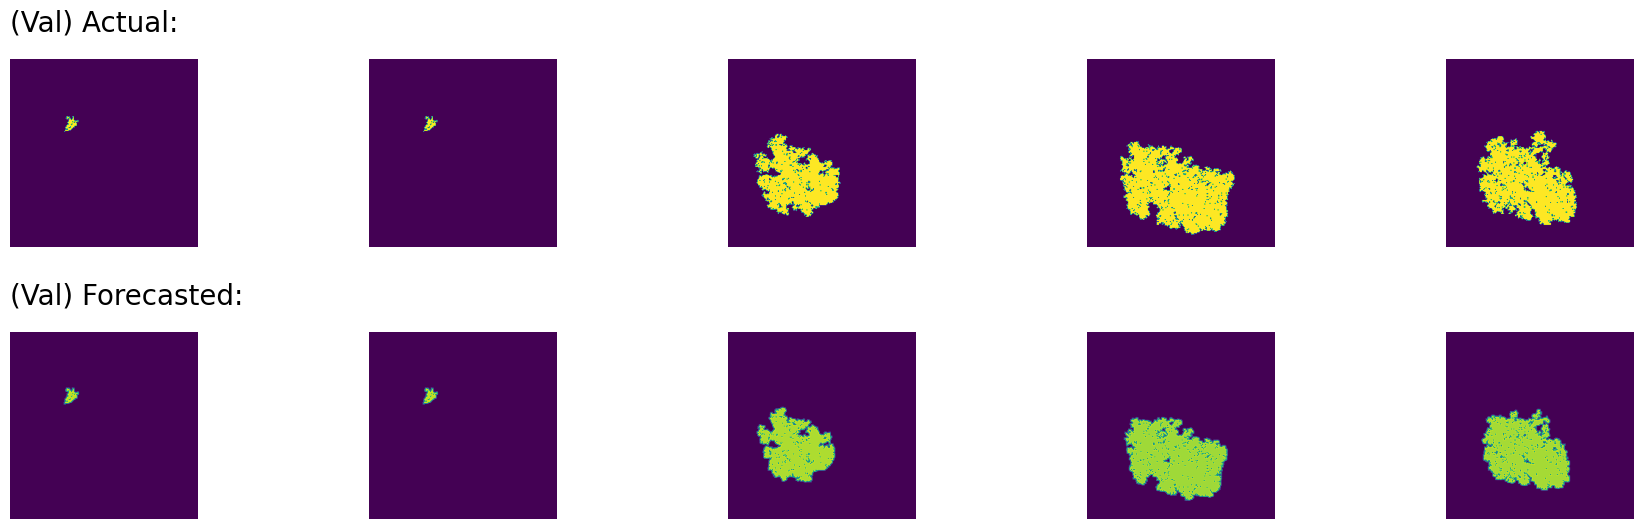

In [57]:
images, labels = next(iter(train_loader))
clstm.eval()

fig, ax = plt.subplots(2, 5, figsize=[18.5, 6])
fig.tight_layout(pad=4)
for n, idx  in enumerate(torch.randint(0,images.shape[0], (5,))):
    _, recon = clstm(images[idx].unsqueeze(0).float())
    ax[0, n].imshow(labels[idx].squeeze())
    ax[0, n].axis('off')
    ax[1, n].imshow(recon.cpu().detach().squeeze())
    ax[1, n].axis('off')
    if n==0:
        ax[0,n].set_title('(Val) Actual:', fontsize=20, pad=20, loc='left')
        ax[1,n].set_title('(Val) Forecasted:', fontsize=20, pad=20, loc='left')

### Plot test results (actual vs forecasted):

In [72]:
background_path = 'data/Ferguson_fire_background.npy'
background_data = np.array(np.load(open(background_path,'rb')))
background_data = background_data.reshape(background_data.shape[0], 1, 1, background_data.shape[])
background_dataset = TensorDataset(torch.Tensor(background_data[:-1]),torch.Tensor(background_data[:-1]))

(5, 256, 256)


ValueError: not enough values to unpack (expected 5, got 3)

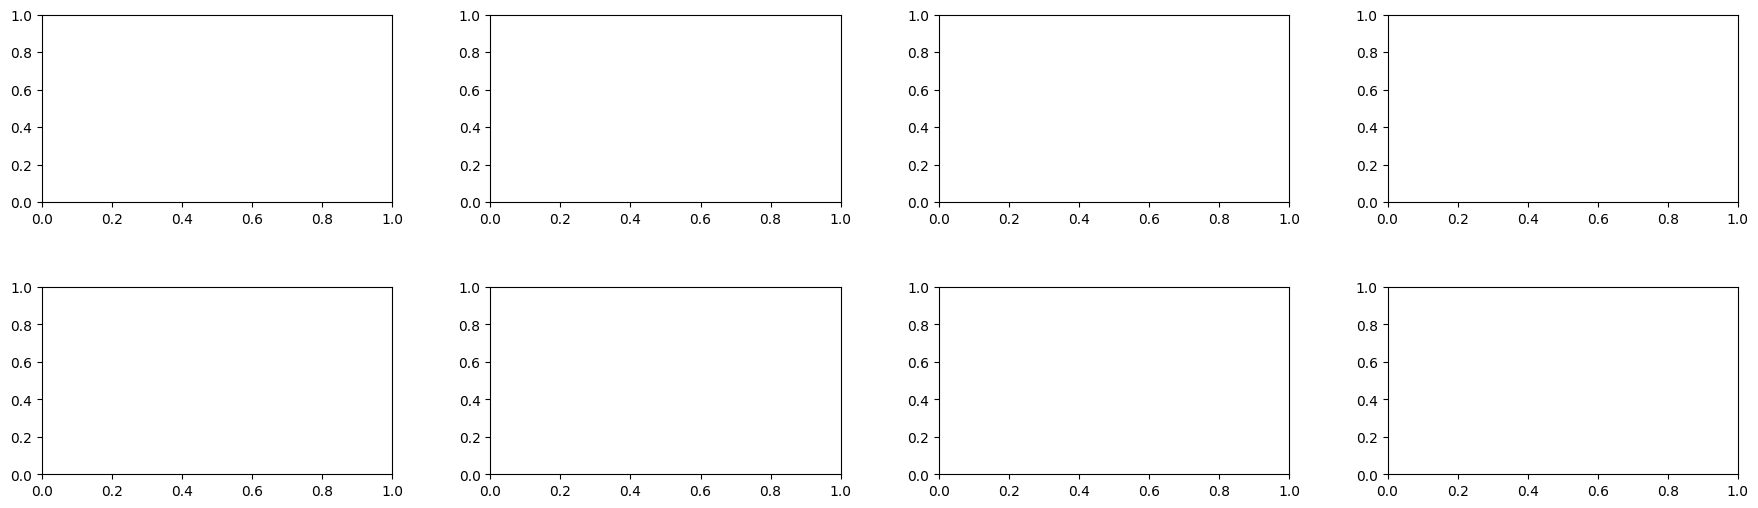

In [70]:
fig, ax = plt.subplots(2, 4, figsize=[18.5, 6])
fig.tight_layout(pad=4)
mses = []

for n,(image, labels) in enumerate(background_dataset):
    _, recon = clstm(image.unsqueeze(0).float()) 
    print(label.shape)
    print(recon.shape)
    mses.append(mean_squared_error(label.flatten(),recon.cpu().detach().squeeze().flatten()))
    ax[0, n].axis('off')
    ax[0, n].imshow(label.squeeze())
    ax[1, n].imshow(recon.cpu().detach().squeeze())
    ax[1, n].axis('off')
    if n==0:
        ax[0,n].set_title('(Test) Actual:', fontsize=20, pad=20, loc='left')
        ax[1,n].set_title('(Test) Forecasted:', fontsize=20, pad=20, loc='left')

### MSE test:

In [ ]:
# print(f'(Test) MSE: {sum(mses)/len(test_dataset)}')